# __Application of a PCM to the argo reference data base__

The aim of this notebook is to apply a Profile Clasification Model (PCM) to the reference profiles chosen by OWC software for correcting an specific profile. The profile WMO is chosen below and the reference profiles comes from the argo reference database. All paths are read from the ow_config.txt file. The notebook produce a .txt including class labels than can be read for the modified version of OWC included in thsi repository. 
The PCM allows to classify oceanographic profiles depending on its shape (look at BlueCloud notebooks). By using the output of this notebooks in the OWC software, only reference profiles in the same class than de float profiles are used to evaluated it, so profiles in the same dynamic region.
Authors
Logos

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
#import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

#from BIC_calculation import *

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#import sys
#np.set_printoptions(threshold=sys.maxsize)

import configparser

### __User inputs__

__1. Configuration file__

Paths are read from the OWC configuration file. You should give the path to this file.

In [2]:
config_filename = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

path to WMO_boxes_latlon.txt

In [3]:
WMOboxes_latlon='WMO_boxes_latlon.txt'

__2. Interpolation depth__

The model can not cope with NaNs should data should be interpolated to the same levels and profiles that are too short will be deleted. Please, choose the max_depth below. We recomend a value around 1000 m, to take into account an important part of the water column in the classification.

In [4]:
# depth for interpolation
max_depth = 900

__3. Season__

Maybe usefull for decorrelation of the training dataset

In [5]:
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all') for training dataset
season = ['all']

__4. Float WMO__

Float you want to correct

In [6]:
# Galicia
#float_mat_path = config['float_source_directory'] + '/test4/6900230.mat'
#float_WMO = 6900230
# agulhas current
#float_mat_path = config['float_source_directory'] + '/test3/3901915.mat'
#float_WMO = 3901915
# southern ocean
#float_mat_path = config['float_source_directory'] + '/test2/3901928.mat'
float_WMO = 3901928
# north atlantic 
#float_mat_path = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/data/float_source/test1/4900136.mat'
#float_WMO = 4900136

__5. Model parameters__

Please choose the number of classes. You can have un idea of the best number of classes in your dataset by using the BIC_calculation notebook

In [7]:
K=4 # number of classes

## 1. Load argo reference database

Important paths are readed form the config file and data is loaded from the argo reference database

Read OWC configuration file

In [8]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

In [9]:
#wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
wmo_boxes='wmo_boxes_argo.mat'
#ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/'
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + '/test2/' + str(float_WMO)+ '.mat'

__Load argo reference database__

Talk about ellipses and PV option

In [10]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = WMOboxes_latlon, 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3300.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3400.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3500.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3600.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3301.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3401.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3501.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3601.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3302.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3402.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_3502.mat
/home5/pharos/argo/DMARGO/OW/VER

In [11]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1024, n_profiles: 35463)
Coordinates:
    long        (n_profiles) float64 9.447 9.116 8.509 ... 359.3 359.2 359.2
    lat         (n_profiles) float64 -48.88 -43.54 -43.28 ... -63.02 -63.11
    dates       (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 2005-06-0...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 35458 35459 35460 35461 35462
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 4.929 10.74 10.83 ... nan nan nan
    sal         (n_pres, n_profiles) float64 33.73 34.4 34.39 ... nan nan nan
    source      (n_profiles) <U45 '1900577_007.BRECKOWENS' ... '7900072_012.O...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


## 2. Create training dataset

Use a regular sampling

In [12]:
ds_t = ds

In [ ]:
%%time
corr_dist = 50 # in km
ds_t = get_regulargrid_dataset(ds, corr_dist, season=season)

In [13]:
print(ds_t)

<xarray.Dataset>
Dimensions:     (n_pres: 1024, n_profiles: 35463)
Coordinates:
    long        (n_profiles) float64 9.447 9.116 8.509 ... 359.3 359.2 359.2
    lat         (n_profiles) float64 -48.88 -43.54 -43.28 ... -63.02 -63.11
    dates       (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 2005-06-0...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 35458 35459 35460 35461 35462
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 4.929 10.74 10.83 ... nan nan nan
    sal         (n_pres, n_profiles) float64 33.73 34.4 34.39 ... nan nan nan
    source      (n_profiles) <U45 '1900577_007.BRECKOWENS' ... '7900072_012.O...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


plot dataset

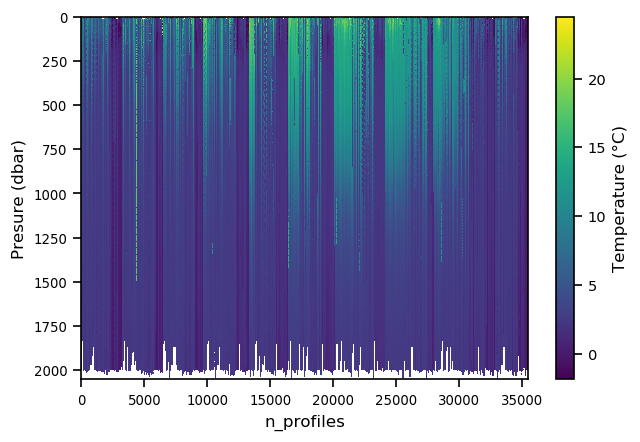

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(np.arange(len(ds_t['n_profiles'])), (len(ds_t['n_pres']),1)), ds_t['pres'], ds_t['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [15]:
std_lev = np.arange(0,max_depth)
ds_t = interpolate_standard_levels(ds_t, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [16]:
# some format
#pres should be negative for the PCM
ds_t['PRES_INTERPOLATED'] = -np.abs(ds_t['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_t.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_t.lat.attrs['axis'] = 'Y'
ds_t.long.attrs['axis'] = 'X'
ds_t.dates.attrs['axis'] = 'T'

In [17]:
print(ds_t)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 35286)
Coordinates:
    long               (n_profiles) float64 9.447 9.116 8.509 ... 359.2 359.2
    lat                (n_profiles) float64 -48.88 -43.54 ... -63.02 -63.11
    dates              (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 35459 35460 35461 35462
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 33.73 ... 34.68
    source             (n_profiles) object '1900577_007.BRECKOWENS' ... '7900...
    temp               (n_profiles, PRES_INTERPOLATED) float64 4.929 ... 0.2091
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


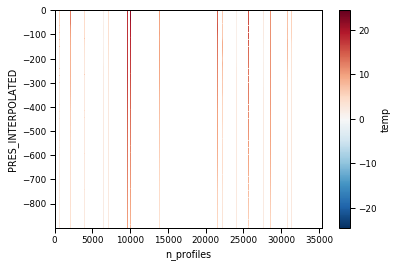

In [18]:
ds_t['temp'].plot(x='n_profiles');

Spatial distribution of training dataset

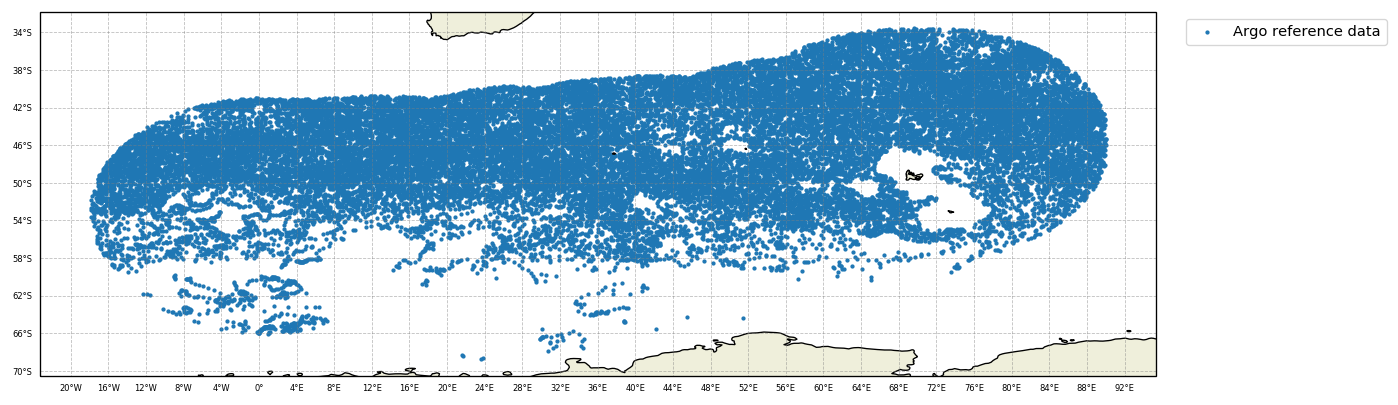

In [19]:
#ds_t = ds
proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_t['long'], ds_t['lat'], s=3, transform=proj, label='Argo reference data')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 3. Create prediction dataset

Add float data to initial dataset

In [20]:
ds_p = add_floatdata(float_WMO, float_mat_path, ds)

In [21]:
print(ds_p)

<xarray.Dataset>
Dimensions:     (n_pres: 1024, n_profiles: 35627)
Coordinates:
    long        (n_profiles) float64 9.447 9.116 8.509 ... 69.79 71.76 72.34
    lat         (n_profiles) float64 -48.88 -43.54 -43.28 ... -46.2 -45.57
    dates       (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 2021-01-01
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 35622 35623 35624 35625 35626
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 4.929 10.74 10.83 ... nan nan nan
    sal         (n_pres, n_profiles) float64 33.73 34.4 34.39 ... nan nan nan
    source      (n_profiles) <U45 '1900577_007.BRECKOWENS' ... 'selected_floa...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


plot dataset

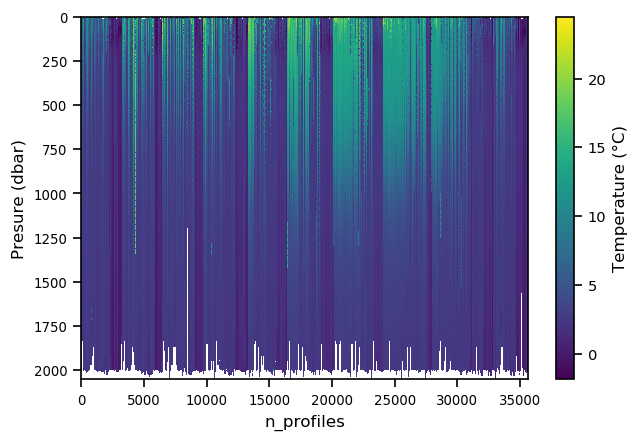

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(ds_p['n_profiles'], (len(ds_p['n_pres']),1)), ds_p['pres'], ds_p['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

__Interpolate to standard levels__

In [23]:
std_lev = np.arange(0,max_depth)
ds_p = interpolate_standard_levels(ds_p, std_lev)

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:128: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [24]:
# some format
#pres should be negative for the PCM
ds_p['PRES_INTERPOLATED'] = -np.abs(ds_p['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_p.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_p.lat.attrs['axis'] = 'Y'
ds_p.long.attrs['axis'] = 'X'
ds_p.dates.attrs['axis'] = 'T'

In [25]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 35449)
Coordinates:
    long               (n_profiles) float64 9.447 9.116 8.509 ... 71.76 72.34
    lat                (n_profiles) float64 -48.88 -43.54 ... -46.2 -45.57
    dates              (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 35623 35624 35625 35626
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 33.73 ... 34.65
    source             (n_profiles) object '1900577_007.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_INTERPOLATED) float64 4.929 ... 2.492
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


__Plot float trajectory and ref profiles__

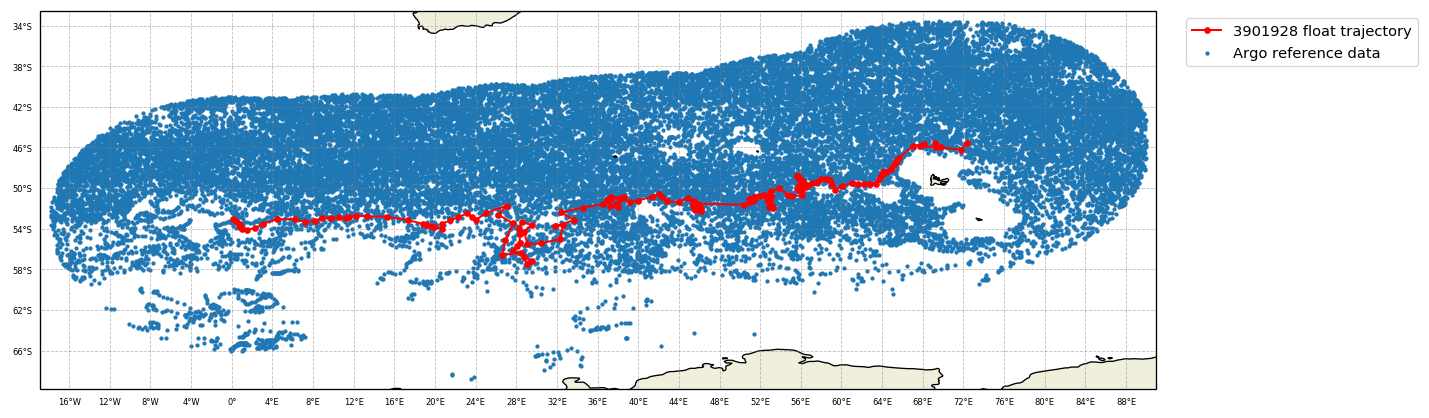

In [26]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if 'selected_float' in isource]

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long']+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].min()-1, ds_p['lat'].max()+1])


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 4. Apply PCM

Create model

In [27]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_t[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: False
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

Fit model

In [28]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit(ds_t, features=features_in_ds, dim=z_dim)
m

<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: True
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 45.739450

Predict labels

In [29]:
#ds_p = ds_t
m.predict(ds_p, features=features_in_ds, inplace = True)
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 35449)
Coordinates:
    long               (n_profiles) float64 9.447 9.116 8.509 ... 71.76 72.34
    lat                (n_profiles) float64 -48.88 -43.54 ... -46.2 -45.57
    dates              (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 35623 35624 35625 35626
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 33.73 ... 34.65
    source             (n_profiles) object '1900577_007.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_INTERPOLATED) float64 4.929 ... 2.492
    PCM_LABELS         (n_profiles) int64 2 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 2 2
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
 

In [ ]:
#ds_p = order_class_names(ds_p, K=K)

In [30]:
m.predict_proba(ds_p, features=features_in_ds, dim=z_dim, inplace=True);

In [31]:
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

In [32]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 35449, pcm_class: 4, quantile: 3)
Coordinates:
  * pcm_class          (pcm_class) int64 0 1 2 3
    long               (n_profiles) float64 9.447 9.116 8.509 ... 71.76 72.34
    lat                (n_profiles) float64 -48.88 -43.54 ... -46.2 -45.57
    dates              (n_profiles) datetime64[ns] 2006-02-16T13:19:44 ... 20...
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 35623 35624 35625 35626
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
  * quantile           (quantile) float64 0.05 0.5 0.95
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 33.73 ... 34.65
    source             (n_profiles) object '1900577_007.BRECKOWENS' ... 'sele...
    temp               (n_profiles, PRES_INTERPOLATED) float64 4.929 ... 2.492
    PCM_LABELS         (n_profiles) int64 

## 6. Plots

In [33]:
P = Plotter(ds_p, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'})
P.data_type = 'profiles'

vertical structure

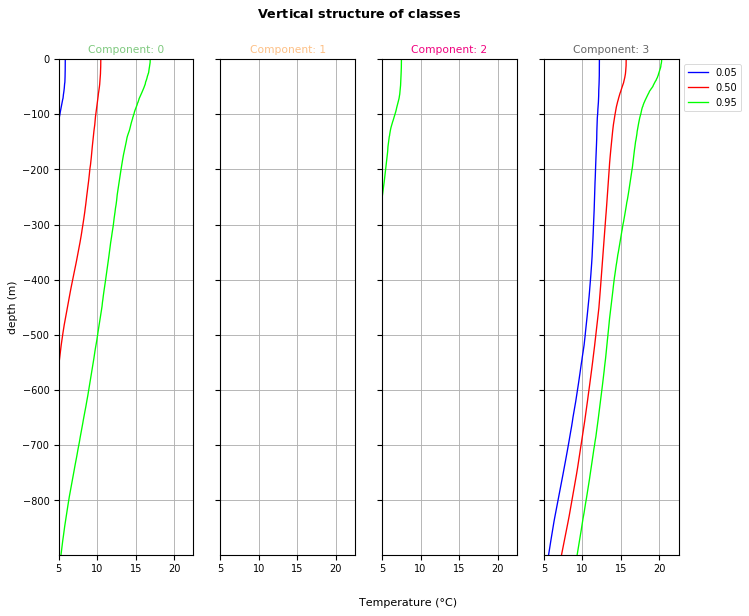

In [34]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)', xlim=[5, 22.5])

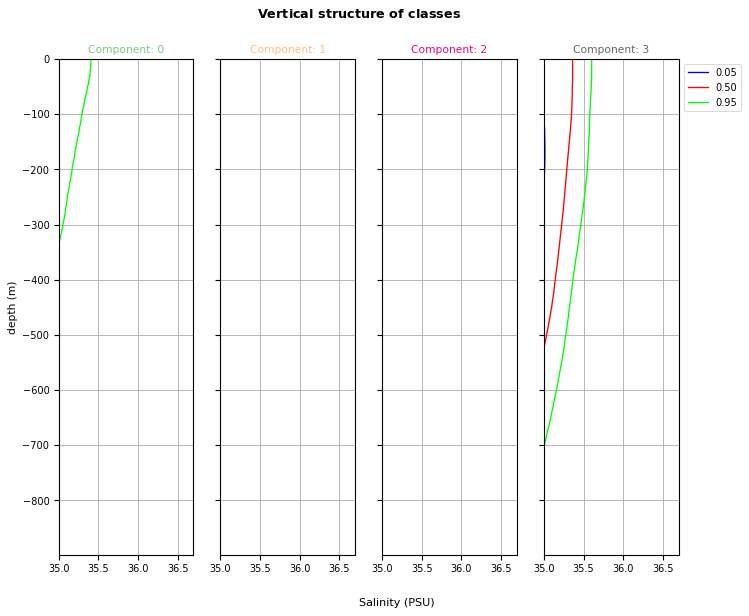

In [35]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', xlim=[35,36.7])

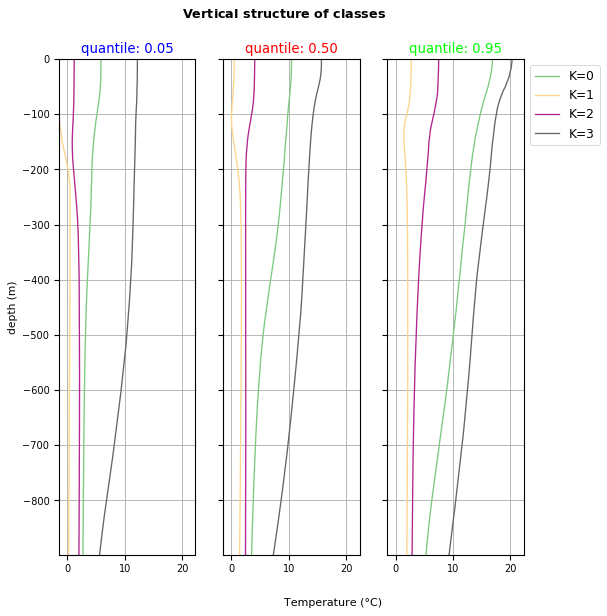

In [36]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

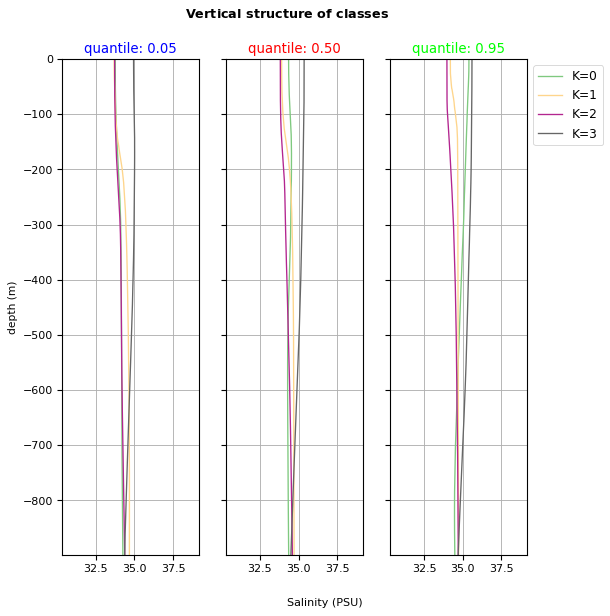

In [37]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)')

spatial distribution

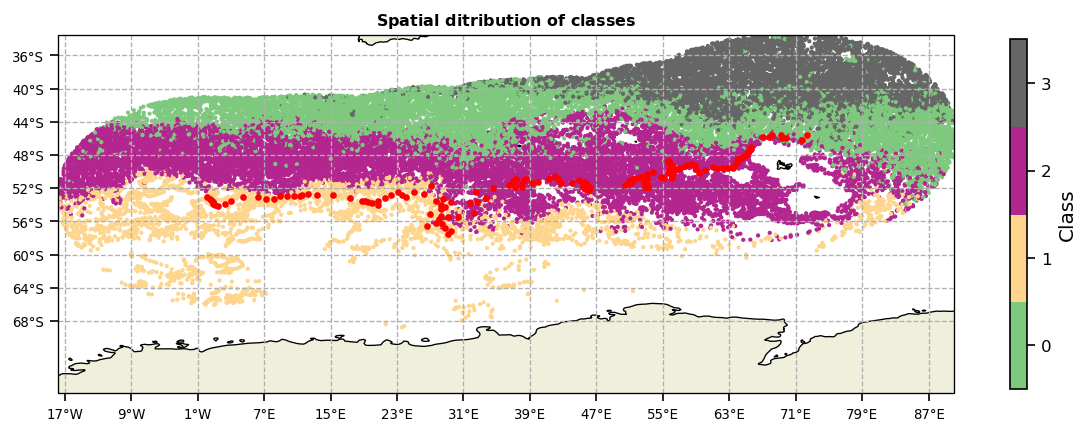

In [38]:
P.spatial_distribution(lonlat_grid =[8,4])

plot float trajectory with classes

plot probability

In [39]:
float_labels = ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
float_post = ds_p['PCM_POST'].isel(n_profiles = selected_float_index, pcm_class = float_labels.astype(np.int16))

No handles with labels found to put in legend.


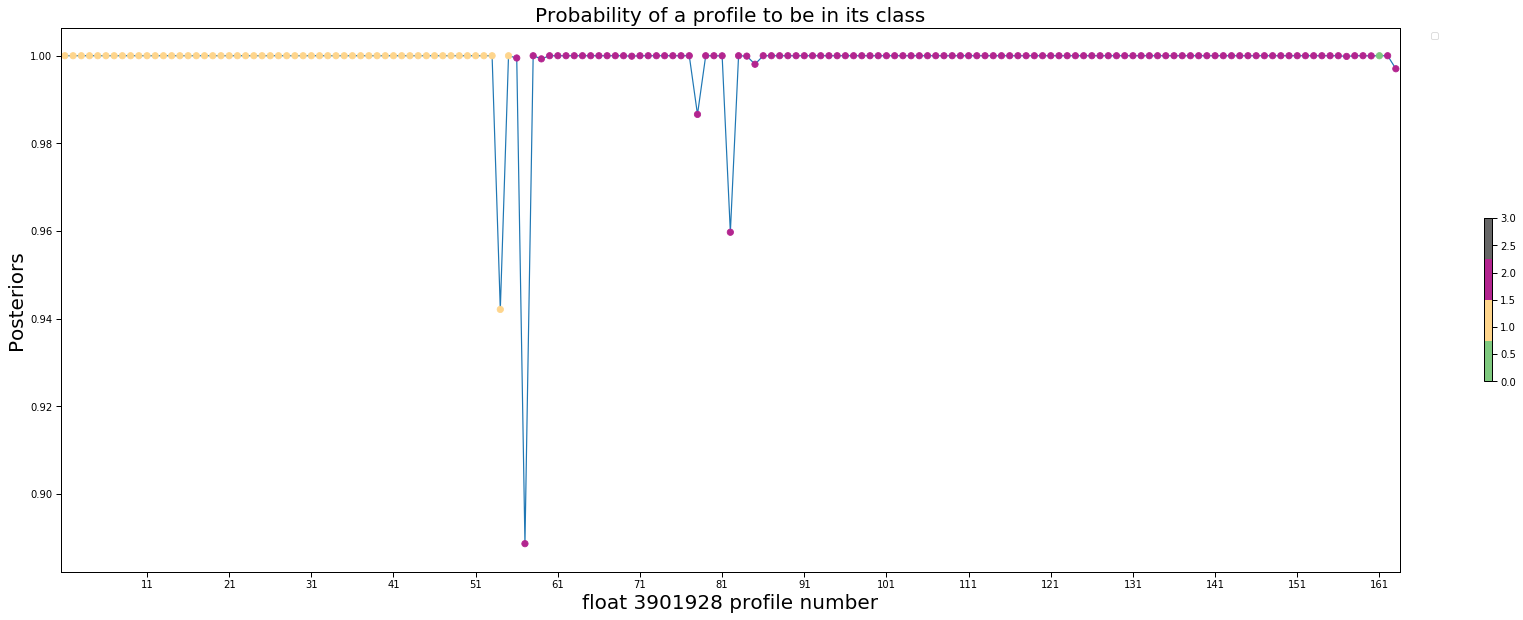

In [41]:
float_source = np.arange(1,len(float_labels)+1)
labels_index = np.arange(10,len(float_source)+1,10)
labels = float_source[labels_index]
kmap = m.plot.cmap(name='Accent')


fig, ax = plt.subplots(figsize=(30, 10))

rects1 = ax.plot(float_source, float_post, '-', zorder=-1)
rects2 = ax.scatter(float_source, float_post, s=40, c=float_labels, cmap=kmap, zorder=1, vmin=0, vmax=K-1)

ax.set_ylabel('Posteriors', fontsize=20)
ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=20)
ax.set_title('Probability of a profile to be in its class', fontsize=20)
ax.set_xticks(labels)
ax.set_xlim([0.5,len(float_source)+0.5])
#ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

cbar = plt.colorbar(rects2, shrink=0.3)
#cbar.set_ticks(np.arange(0.5, K+0.5))
#cbar.set_ticklabels(range(K))

In [ ]:
ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
#ds_p['source'].isel(n_profiles = selected_float_index)

In [ ]:
len(ds_p['source'].isel(n_profiles = selected_float_index))

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if 'selected_float' in isource]

kmap = m.plot.cmap(name='Accent')

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data', alpha=0)

p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'k-', transform=proj)

p2 = ax.scatter(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                s=20, c=ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index), cmap=kmap, transform=proj)
#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data')

#p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
#                 'b-', transform=proj, markersize = 3, markerfacecolor="None", label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long'].isel(n_profiles = selected_float_index)+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].isel(n_profiles = selected_float_index).min()-1, ds_p['lat'].isel(n_profiles = selected_float_index).max()+1])

cbar = plt.colorbar(p1, shrink=0.3)
cbar.set_ticks(np.arange(0.5, K+0.5))
#cbar.set_ticklabels(range(K))

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
range(K)

Classes pie chart

In [ ]:
P.pie_classes()

Temporal representation

Bar plot by month

In [ ]:
P.temporal_distribution(time_bins = 'month')

Bar plot by season

In [ ]:
P.temporal_distribution(time_bins = 'season')

## 7. Output

Create a .txt file with classes

In [ ]:
#create array with source, lat, long and PCM_labels
# change long values to 0-360 as used in OW
#long_360 = np.mod(ds_p['long'].values, 360)

matrix_txt = np.stack(('"'+ ds_p['source'].values + '"', ds_p['lat'].values, ds_p['long'].values, ds_p['PCM_LABELS'].values), axis=1)
#matrix_txt = np.stack((ds_p['source'].values, ds_p['lat'].values, long_360, ds_p['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'
print([ds_p['long'].min(), ds_p['long'].max()])

f= open("output_files/PCM_classes_6900230_CTD_k4.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%.1f'], header=header)
f.close() 

In [ ]:
m.to_netcdf('model_CTD_6900230_K4.nc')

## 8. Plot with AVISO

Load AVISO data

In [ ]:
path_aviso = '/home1/homedir5/perso/agarciaj/EARISE/data/AVISO_gulfstream_2004.nc'
ds_aviso = xr.open_dataset(path_aviso)
ds_aviso

In [ ]:
ds_aviso['longitude'] = np.mod((ds_aviso.longitude.values+180),360)-180
ds_aviso

In [ ]:
time_step = '2004-09-03'

scatter plot using class

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.pcolormesh(ds_aviso['longitude'], ds_aviso['latitude'], ds_aviso['adt'].sel(time = time_step), cmap='bwr', transform=proj)
p1 = ax.scatter(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
                 s=8, c=ds_out['PCM_LABELS'].isel(n_profiles = selected_float_index), transform=proj, cmap='Accent')
#p2 = ax.scatter(ds_out['long'], ds_out['lat'], s=3, transform=proj, label='Argo reference data')
#p3 = ax.plot(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
#                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim([-64,-48])
legend1 = ax.legend(*p1.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)